## Question: Are soccer referees more likely to give red cards to dark-skin-toned players than light-skin-toned players?

##### -> GridSpec: Specifies the geometry of the grid that a subplot can be placed in. 
##### -> tqdm: To show the progress
##### -> missingno: provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset


In [1]:
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time
from pandas.plotting import scatter_matrix

### DATA:

| Variable Name: | Variable Description: | 
| -- | -- | 
| playerShort | short player ID | 
| player | player name | 
| club | player club | 
| leagueCountry | country of player club (England, Germany, France, and Spain) | 
| height | player height (in cm) | 
| weight | player weight (in kg) | 
| position | player position | 
| games | number of games in the player-referee dyad | 
| goals | number of goals in the player-referee dyad | 
| yellowCards | number of yellow cards player received from the referee | 
| yellowReds | number of yellow-red cards player received from the referee | 
| redCards | number of red cards player received from the referee | 
| photoID | ID of player photo (if available) | 
| rater1 | skin rating of photo by rater 1 | 
| rater2 | skin rating of photo by rater 2 | 
| refNum | unique referee ID number (referee name removed for anonymizing purposes) | 
| refCountry | unique referee country ID number | 
| meanIAT | mean implicit bias score (using the race IAT) for referee country | 
| nIAT | sample size for race IAT in that particular country | 
| seIAT | standard error for mean estimate of race IAT   | 
| meanExp | mean explicit bias score (using a racial thermometer task) for referee country | 
| nExp | sample size for explicit bias in that particular country | 
| seExp |  standard error for mean estimate of explicit bias measure | 

In [2]:
#Read the data
data_df = pd.read_csv('../data/redcard.csv')
data_df.head()

playerShort         player             club leagueCountry    birthday  \
0  lucas-wilchez  Lucas Wilchez    Real Zaragoza         Spain  31.08.1983   
1     john-utaka     John Utaka  Montpellier HSC        France  08.01.1982   
2    abdon-prats    Abdón Prats     RCD Mallorca         Spain  17.12.1992   
3     pablo-mari     Pablo Marí     RCD Mallorca         Spain  31.08.1993   
4     ruben-pena     Rubén Peña  Real Valladolid         Spain  18.07.1991   

   height  weight              position  games  victories  ...  rater2  \
0   177.0    72.0  Attacking Midfielder      1          0  ...    0.50   
1   179.0    82.0          Right Winger      1          0  ...    0.75   
2   181.0    79.0                   NaN      1          0  ...     NaN   
3   191.0    87.0           Center Back      1          1  ...     NaN   
4   172.0    70.0      Right Midfielder      1          1  ...     NaN   

   refNum  refCountry  Alpha_3   meanIAT    nIAT     seIAT   meanExp    nExp  \
0       1           1      GRC  0.326391   712.0  0.000564  0.396000   750.0   
1       2           2      ZMB  0.203375    40.0  0.010875 -0.204082    49.0   
2       3           3      ESP  0.369894  1785.0  0.000229  0.588297  1897.0   
3       3           3      ESP  0.369894  1785.0  0.000229  0.588297  1897.0   
4       3           3      ESP  0.369894  1785.0  0.000229  0.588297  1897.0   

      seExp  
0  0.002696  
1  0.061504  
2  0.001002  
3  0.001002  
4  0.001002  

[5 rows x 28 columns]

In [3]:
data_df.shape

(146028, 28)

In [4]:
data_df.describe().T

count          mean            std           min          25%  \
height       145765.0    181.935938       6.738726  1.610000e+02   177.000000   
weight       143785.0     76.075662       7.140906  5.400000e+01    71.000000   
games        146028.0      2.921166       3.413633  1.000000e+00     1.000000   
victories    146028.0      1.278344       1.790725  0.000000e+00     0.000000   
ties         146028.0      0.708241       1.116793  0.000000e+00     0.000000   
defeats      146028.0      0.934581       1.383059  0.000000e+00     0.000000   
goals        146028.0      0.338058       0.906481  0.000000e+00     0.000000   
yellowCards  146028.0      0.385364       0.795333  0.000000e+00     0.000000   
yellowReds   146028.0      0.011381       0.107931  0.000000e+00     0.000000   
redCards     146028.0      0.012559       0.112889  0.000000e+00     0.000000   
rater1       124621.0      0.264255       0.295382  0.000000e+00     0.000000   
rater2       124621.0      0.302862       0.293020  0.000000e+00     0.000000   
refNum       146028.0   1534.827444     918.736625  1.000000e+00   641.000000   
refCountry   146028.0     29.642842      27.496189  1.000000e+00     7.000000   
meanIAT      145865.0      0.346276       0.032246 -4.725423e-02     0.334684   
nIAT         145865.0  19697.411216  127126.197143  2.000000e+00  1785.000000   
seIAT        145865.0      0.000631       0.004736  2.235373e-07     0.000055   
meanExp      145865.0      0.452026       0.217469 -1.375000e+00     0.336101   
nExp         145865.0  20440.233860  130615.745103  2.000000e+00  1897.000000   
seExp        145865.0      0.002994       0.019723  1.043334e-06     0.000225   

                     50%          75%           max  
height        182.000000   187.000000  2.030000e+02  
weight         76.000000    81.000000  1.000000e+02  
games           2.000000     3.000000  4.700000e+01  
victories       1.000000     2.000000  2.900000e+01  
ties            0.000000     1.000000  1.400000e+01  
defeats         1.000000     1.000000  1.800000e+01  
goals           0.000000     0.000000  2.300000e+01  
yellowCards     0.000000     1.000000  1.400000e+01  
yellowReds      0.000000     0.000000  3.000000e+00  
redCards        0.000000     0.000000  2.000000e+00  
rater1          0.250000     0.250000  1.000000e+00  
rater2          0.250000     0.500000  1.000000e+00  
refNum       1604.000000  2345.000000  3.147000e+03  
refCountry     21.000000    44.000000  1.610000e+02  
meanIAT         0.336628     0.369894  5.737933e-01  
nIAT         2882.000000  7749.000000  1.975803e+06  
seIAT           0.000151     0.000229  2.862871e-01  
meanExp         0.356446     0.588297  1.800000e+00  
nExp         3011.000000  7974.000000  2.029548e+06  
seExp           0.000586     0.001002  1.060660e+00

In [5]:
data_df.dtypes

playerShort       object
player            object
club              object
leagueCountry     object
birthday          object
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
dtype: object

In [6]:
columns = data_df.columns.tolist()
columns

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

### Questions on the dataset
How do we operationalize the question of referees giving more red cards to dark skinned players?
* Counterfactual: if the player were lighter, a ref is more likely to have given a yellow or no card **for the same offense under the same conditions**
* Regression: accounting for confounding, darker players have positive coefficient on regression against proportion red/total card

Potential issues
* How to combine rater1 and rater2? Average them? What if they disagree? Throw it out?
* Is data imbalanced, i.e. red cards are very rare?
* Is data biased, i.e. players have different amounts of play time? Is this a summary of their whole career?
* How do I know I've accounted for all forms of confounding?

**First, is there systematic discrimination across all refs?**

Exploration/hypotheses:
* Distribution of games played
* red cards vs games played
* Reds per game played vs total cards per game played by skin color
* Distribution of # red, # yellow, total cards, and fraction red per game played for all players by avg skin color
* How many refs did players encounter?
* Do some clubs play more aggresively and get carded more? Or are more reserved and get less?
* Does carding vary by leagueCountry?
* Do high scorers get more slack (fewer cards) for the same position?
* Are there some referees that give more red/yellow cards than others?
* how consistent are raters? Check with Cohen's kappa.
* how do red cards vary by position? e.g. defenders get more?
* Do players with more games get more cards, and is there difference across skin color?
* indication of bias depending on refCountry?

### Data Cleaning

Create multiple tables for 
* players
* refrees
* clubs
* countries
* dyands (player-refree combo)

### Players

In [7]:
players_index = 'playerShort'
players_cols = [
               'player',
               'birthday',
               'height',
               'weight',
               'position',
               'photoID',
               'rater1',
               'rater2',
]

In [8]:
#Check if we have duplicate entries
#If the same player has different values in differnt rows, then the cell value will be > 1
all_cols_unique_players = data_df.groupby('playerShort').agg({col:'nunique' for col in players_cols})
all_cols_unique_players.head()

player  birthday  height  weight  position  photoID  \
playerShort                                                                   
aaron-hughes                 1         1       1       1         1        1   
aaron-hunt                   1         1       1       1         1        1   
aaron-lennon                 1         1       1       1         1        1   
aaron-ramsey                 1         1       1       1         1        1   
abdelhamid-el-kaoutari       1         1       1       1         1        1   

                        rater1  rater2  
playerShort                             
aaron-hughes                 1       1  
aaron-hunt                   1       1  
aaron-lennon                 1       1  
aaron-ramsey                 1       1  
abdelhamid-el-kaoutari       1       1

In [9]:
all_cols_unique_players[all_cols_unique_players > 1].dropna().shape[0] == 0

True

#### This being ```True``` says that all the values are same per player across multiple rows

In [10]:
def get_subgroup(dataframe, g_index, g_columns):
    '''
    purpose: Group the dataframe based on index and check for the group's uniqueness
    parameters:
        dataframe: DF on which grouping and uniqueness test needs to be done
        g_index: Index for grouping
        g_columns: Columns for grouping
    return:
        Dataframe with unique entries and max value for each column
    '''
    g = dataframe.groupby(g_index).agg({col:'nunique' for col in g_columns})
    if g[g > 1].dropna().shape[0] != 0:
        print("This group doesn't have unique values")
    return dataframe.groupby(g_index).agg({col:'max' for col in g_columns})

In [11]:
players = get_subgroup(data_df,players_index, players_cols)
players.head()

player    birthday  height  weight  \
playerShort                                                                  
aaron-hughes                      Aaron Hughes  08.11.1979   182.0    71.0   
aaron-hunt                          Aaron Hunt  04.09.1986   183.0    73.0   
aaron-lennon                      Aaron Lennon  16.04.1987   165.0    63.0   
aaron-ramsey                      Aaron Ramsey  26.12.1990   178.0    76.0   
abdelhamid-el-kaoutari  Abdelhamid El-Kaoutari  17.03.1990   180.0    73.0   

                                    position     photoID  rater1  rater2  
playerShort                                                               
aaron-hughes                     Center Back    3868.jpg    0.25    0.00  
aaron-hunt              Attacking Midfielder   20136.jpg    0.00    0.25  
aaron-lennon                Right Midfielder   13515.jpg    0.25    0.25  
aaron-ramsey               Center Midfielder   94953.jpg    0.00    0.00  
abdelhamid-el-kaoutari           Center Back  124913.jpg    0.25    0.25

### Club

In [12]:
club_index = 'club'
club_cols = ['leagueCountry']
clubs = get_subgroup(data_df,club_index,club_cols)
clubs.head()

leagueCountry
club                         
1. FC Nürnberg        Germany
1. FSV Mainz 05       Germany
1899 Hoffenheim       Germany
AC Ajaccio             France
AFC Bournemouth       England

In [13]:
clubs.leagueCountry.value_counts()

England    48
Spain      27
France     22
Germany    21
Name: leagueCountry, dtype: int64

### Referee

In [14]:
referee_index = 'refNum'
referee_cols = ['refCountry']
refrees = get_subgroup(data_df,referee_index,referee_cols)
refrees.head()

refCountry
refNum            
1                1
2                2
3                3
4                4
5                5

In [15]:
refrees.refCountry.nunique()

161

### Countries

In [16]:
countries_index = 'refCountry'
countries_cols = [
                'Alpha_3', # rename this name of country
                'meanIAT',
                'nIAT',
                'seIAT',
                'meanExp',
                'nExp',
                'seExp',
]
countries = get_subgroup(data_df,countries_index,countries_cols)
countries.head()

Alpha_3   meanIAT    nIAT     seIAT   meanExp    nExp     seExp
refCountry                                                                
1              GRC  0.326391   712.0  0.000564  0.396000   750.0  0.002696
2              ZMB  0.203375    40.0  0.010875 -0.204082    49.0  0.061504
3              ESP  0.369894  1785.0  0.000229  0.588297  1897.0  0.001002
4              LUX  0.325185   127.0  0.003297  0.538462   130.0  0.013752
5              TUN  0.167132    19.0  0.027327 -0.789474    19.0  0.111757

In [17]:
rename_cols = {'Alpha_3':'countryName'}
countries = countries.rename(columns=rename_cols)
countries.head()

countryName   meanIAT    nIAT     seIAT   meanExp    nExp     seExp
refCountry                                                                    
1                  GRC  0.326391   712.0  0.000564  0.396000   750.0  0.002696
2                  ZMB  0.203375    40.0  0.010875 -0.204082    49.0  0.061504
3                  ESP  0.369894  1785.0  0.000229  0.588297  1897.0  0.001002
4                  LUX  0.325185   127.0  0.003297  0.538462   130.0  0.013752
5                  TUN  0.167132    19.0  0.027327 -0.789474    19.0  0.111757

### Dyads

In [18]:
dyands_index = ['refNum', 'playerShort']
dyands_cols = [
            'games',
             'victories',
             'ties',
             'defeats',
             'goals',
             'yellowCards',
             'yellowReds',
             'redCards',
]
dyands = get_subgroup(data_df,dyands_index,dyands_cols)
dyands.head(10)

games  victories  ties  defeats  goals  \
refNum playerShort                                                  
1      lucas-wilchez           1          0     0        1      0   
2      john-utaka              1          0     0        1      0   
3      abdon-prats             1          0     1        0      0   
       pablo-mari              1          1     0        0      0   
       ruben-pena              1          1     0        0      0   
4      aaron-hughes            1          0     0        1      0   
       aleksandar-kolarov      1          1     0        0      0   
       alexander-tettey        1          0     0        1      0   
       anders-lindegaard       1          0     1        0      0   
       andreas-beck            1          1     0        0      0   

                           yellowCards  yellowReds  redCards  
refNum playerShort                                            
1      lucas-wilchez                 0           0         0  
2      john-utaka                    1           0         0  
3      abdon-prats                   1           0         0  
       pablo-mari                    0           0         0  
       ruben-pena                    0           0         0  
4      aaron-hughes                  0           0         0  
       aleksandar-kolarov            0           0         0  
       alexander-tettey              0           0         0  
       anders-lindegaard             0           0         0  
       andreas-beck                  0           0         0

In [19]:
#get those rows where #redcards > 1
dyands[dyands['redCards']>1]

games  victories  ties  defeats  goals  \
refNum playerShort                                                    
140    bodipo                    6          2     1        3      1   
367    antonio-lopez_2           8          5     2        1      0   
432    javi-martinez            14          4     3        7      2   
       jonas                     9          1     4        4      1   
487    phil-jagielka             7          2     1        4      1   
586    cyril-jeunechamp         14          8     0        6      0   
804    sergio-ramos             18         12     1        5      4   
985    aly-cissokho              9          1     5        3      1   
1114   eugen-polanski            8          4     0        4      0   
1214   emmanuel-adebayor        23          9     7        7     10   
1349   jose-nunes                6          2     2        2      0   
1574   jesus-rueda               6          0     2        4      0   
1696   marc-planus              19         10     6        3      0   
1886   de-lucas                 10          3     3        4      0   
1931   fallou-diagne             3          0     0        3      0   
2080   laurent-koscielny        14          5     2        7      1   
2246   saber-khelifa             5          1     1        3      0   
2370   ivo-ilicevic              9          3     4        2      0   
2796   fabien-audard             8          2     3        3      0   
2803   cristiano-ronaldo        22         15     3        4      9   
2822   gary-cahill               5          2     1        2      0   
       lee-cattermole            4          1     2        1      0   
2961   cyril-jeunechamp         11          5     3        3      0   
       mouhamadou-dabo           4          3     0        1      0   
3099   rafael-van-der-vaart     14          6     2        6      3   

                             yellowCards  yellowReds  redCards  
refNum playerShort                                              
140    bodipo                          0           0         2  
367    antonio-lopez_2                 2           0         2  
432    javi-martinez                   2           0         2  
       jonas                           0           0         2  
487    phil-jagielka                   0           0         2  
586    cyril-jeunechamp                6           0         2  
804    sergio-ramos                    6           1         2  
985    aly-cissokho                    1           0         2  
1114   eugen-polanski                  0           0         2  
1214   emmanuel-adebayor               4           1         2  
1349   jose-nunes                      0           0         2  
1574   jesus-rueda                     0           0         2  
1696   marc-planus                     1           0         2  
1886   de-lucas                        1           0         2  
1931   fallou-diagne                   0           0         2  
2080   laurent-koscielny               4           0         2  
2246   saber-khelifa                   0           0         2  
2370   ivo-ilicevic                    1           0         2  
2796   fabien-audard                   0           0         2  
2803   cristiano-ronaldo               4           0         2  
2822   gary-cahill                     0           0         2  
       lee-cattermole                  1           0         2  
2961   cyril-jeunechamp                3           0         2  
       mouhamadou-dabo                 0           0         2  
3099   rafael-van-der-vaart            4           0         2

In [20]:
dyands.redCards.max()

2

## Analysis

### Players

In [21]:
players.shape

(2053, 8)

In [22]:
players.columns

Index(['player', 'birthday', 'height', 'weight', 'position', 'photoID',
       'rater1', 'rater2'],
      dtype='object')

In [23]:
#players name adds no value
players.drop('player', axis=1, inplace=True)
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  
playerShort                                         
aaron-hughes              3868.jpg    0.25    0.00  
aaron-hunt               20136.jpg    0.00    0.25  
aaron-lennon             13515.jpg    0.25    0.25  
aaron-ramsey             94953.jpg    0.00    0.00  
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25

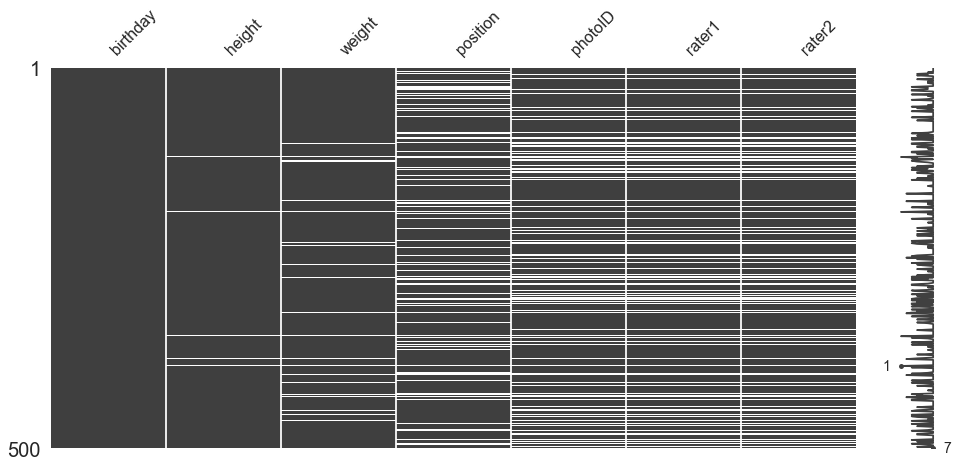

In [24]:
#Visualize the missing data on a sample of 500 records
msno.matrix(players.sample(500),
            figsize=(16,7),
            width_ratios=(15,1)
           )

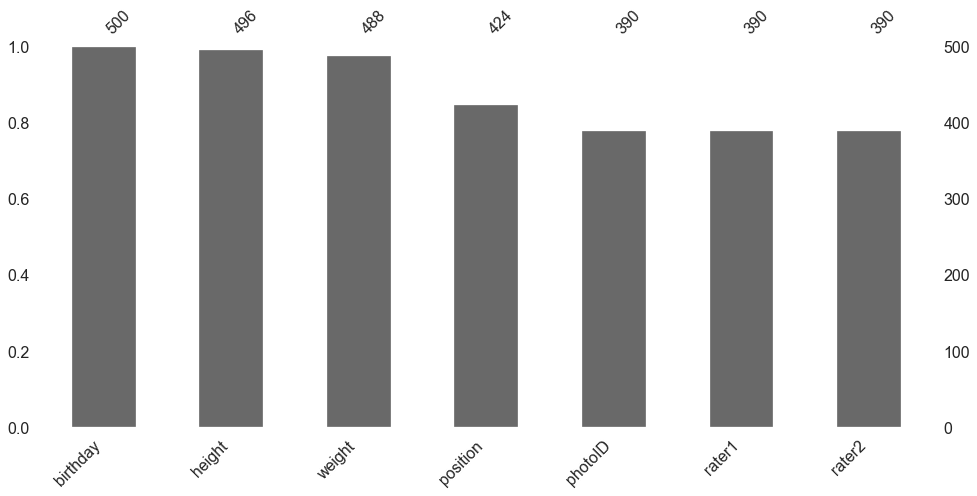

In [25]:
msno.bar(
    players.sample(500),
    figsize=(16,7)
)

### Insight: Most of the players have no rating from either of the raters.
### Action: Does the missing data have any correlations? -> Genrate a heatmap

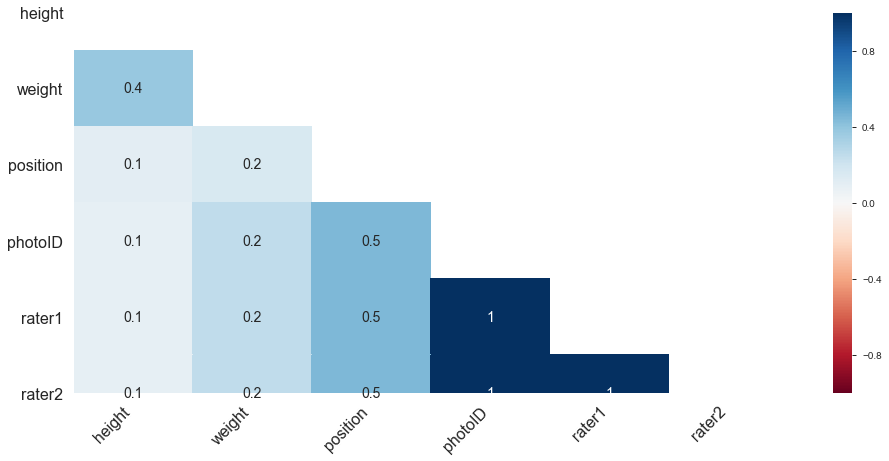

In [26]:
msno.heatmap(players.sample(500),figsize=(16,7))

### Insight: PhotoID is correlated with the rater1 and rater2

In [27]:
#Check for number of missing values
print("# players: ", len(players))
print("# rater1 missing: ", len(players[(players.rater1.isnull())]))
print("# rater2 missing: ", len(players[(players.rater2.isnull())]))
print("# rater1 & rater2 missing: ", len(players[(players.rater1.isnull()) & (players.rater2.isnull())]))

# players:  2053
# rater1 missing:  468
# rater2 missing:  468
# rater1 & rater2 missing:  468


In [28]:
#Get the dataframe with no nulls
players = players[players.rater1.notnull()]
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  
playerShort                                         
aaron-hughes              3868.jpg    0.25    0.00  
aaron-hunt               20136.jpg    0.00    0.25  
aaron-lennon             13515.jpg    0.25    0.25  
aaron-ramsey             94953.jpg    0.00    0.00  
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25

In [29]:
len(players)

1585

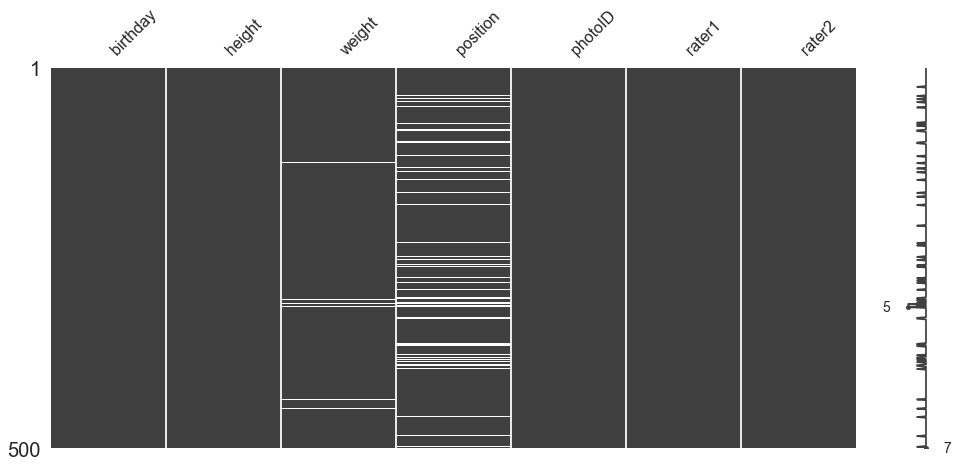

In [30]:
msno.matrix(players.sample(500),figsize=(16,7))

Now that each player has both ratings, how are combining them? But, before combinig, are they close enough to combine?
How to check close enough? -> Correlations

(5.0, 0.0)

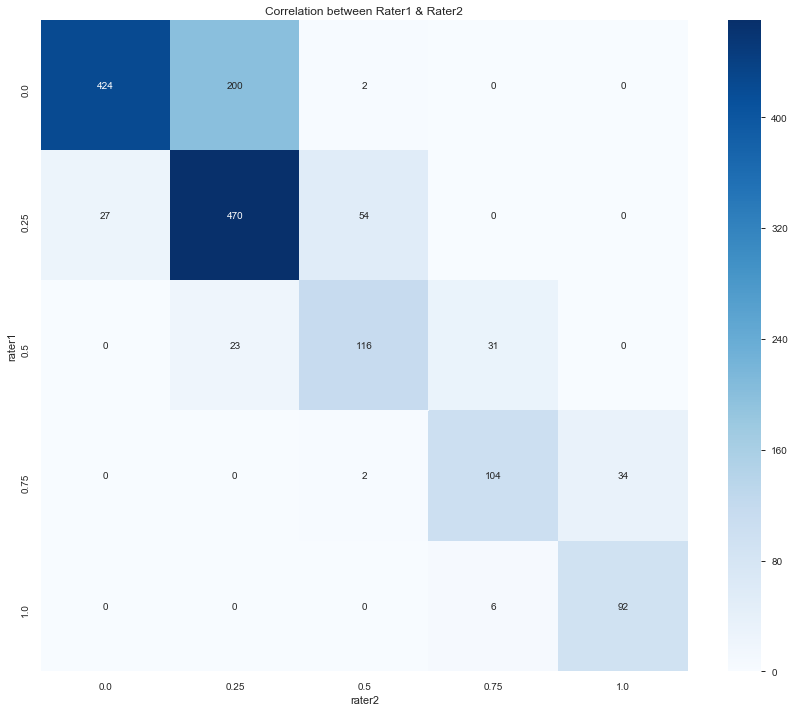

In [31]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap='Blues', annot=True, fmt = 'd', ax=ax)
ax.set_title('Correlation between Rater1 & Rater2')
fig.tight_layout()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From this, we can see that, both ther raters rated approximately the same. Therefore combine the ratings by averaging them.

In [32]:
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  
playerShort                                         
aaron-hughes              3868.jpg    0.25    0.00  
aaron-hunt               20136.jpg    0.00    0.25  
aaron-lennon             13515.jpg    0.25    0.25  
aaron-ramsey             94953.jpg    0.00    0.00  
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25

In [33]:
players['skinTone'] = players[['rater1','rater2']].mean(axis=1)
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  skinTone  
playerShort                                                   
aaron-hughes              3868.jpg    0.25    0.00     0.125  
aaron-hunt               20136.jpg    0.00    0.25     0.125  
aaron-lennon             13515.jpg    0.25    0.25     0.250  
aaron-ramsey             94953.jpg    0.00    0.00     0.000  
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25     0.250

# Analyze the data distributions

## skinTone

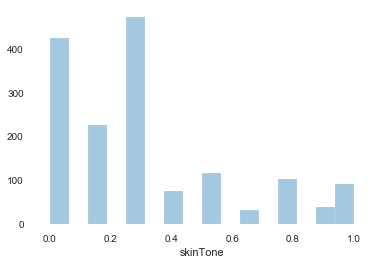

In [34]:
sns.distplot(players.skinTone,kde=False)

### Position
the position of the player might affect the redCard. like, chances of a defender getting a red might be more than a keeper

Text(0.5, 0, 'Counts')

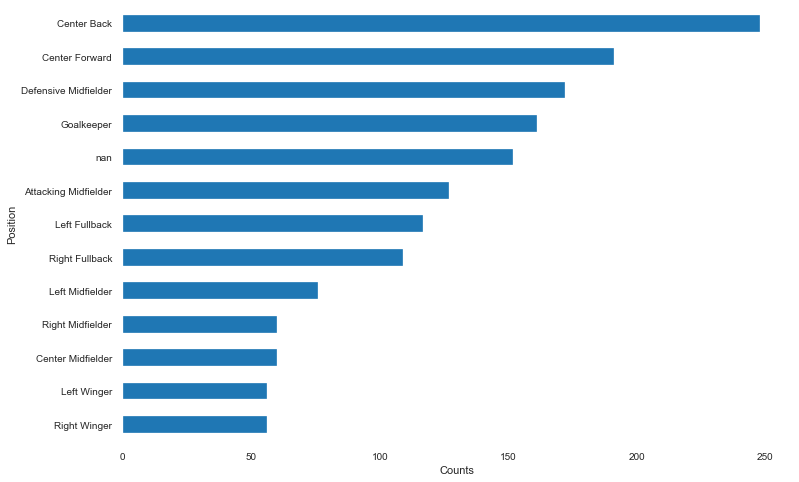

In [35]:
MIDSIZE = (12,8)
fig,ax = plt.subplots(figsize=MIDSIZE)
players.position.value_counts(dropna=False, ascending=True).plot(kind='barh',ax=ax)
ax.set_ylabel("Position")
ax.set_xlabel("Counts")
# fig.tight_layout()

Create high level categories for positions

In [36]:
positions = players.position.unique()
positions

array(['Center Back', 'Attacking Midfielder', 'Right Midfielder',
       'Center Midfielder', 'Goalkeeper', 'Defensive Midfielder',
       'Left Fullback', nan, 'Left Midfielder', 'Right Fullback',
       'Center Forward', 'Left Winger', 'Right Winger'], dtype=object)

In [37]:
defense = ['Center Back','Defensive Midfielder', 'Left Fullback', 'Right Fullback']
midfield = ['Right Midfielder', 'Center Midfielder', 'Left Midfielder']
forward = ['Attacking Midfielder', 'Left Winger', 'Right Winger', 'Center Forward']
keeper = ['Goalkeeper']

#Modify the DF
players.loc[players['position'].isin(defense), 'position_agg'] = 'Defence'
players.loc[players['position'].isin(midfield), 'position_agg'] = 'MidField'
players.loc[players['position'].isin(forward), 'position_agg'] = 'Forward'
players.loc[players['position'].isin(keeper), 'position_agg'] = 'Keeper'
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  skinTone position_agg  
playerShort                                                                
aaron-hughes              3868.jpg    0.25    0.00     0.125      Defence  
aaron-hunt               20136.jpg    0.00    0.25     0.125      Forward  
aaron-lennon             13515.jpg    0.25    0.25     0.250     MidField  
aaron-ramsey             94953.jpg    0.00    0.00     0.000     MidField  
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25     0.250      Defence

Text(0.5, 0, 'Counts')

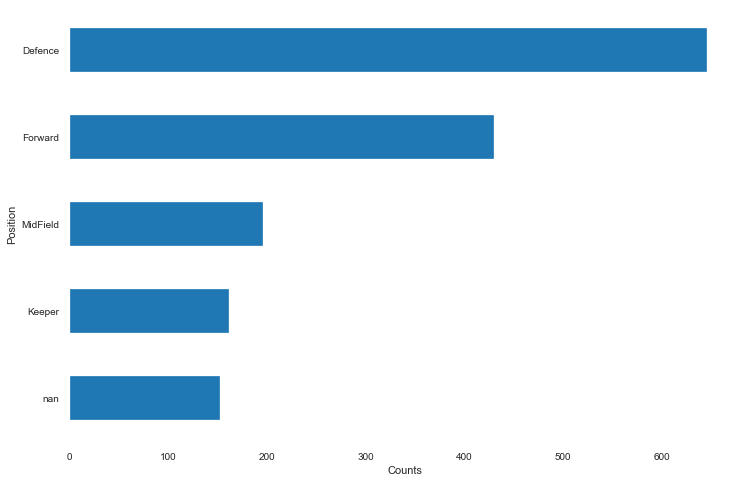

In [38]:
MIDSIZE = (12,8)
fig,ax = plt.subplots(figsize=MIDSIZE)
players.position_agg.value_counts(dropna=False, ascending=True).plot(kind='barh',ax=ax)
ax.set_ylabel("Position")
ax.set_xlabel("Counts")
# fig.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CE02FB8848>,
      dtype=object)

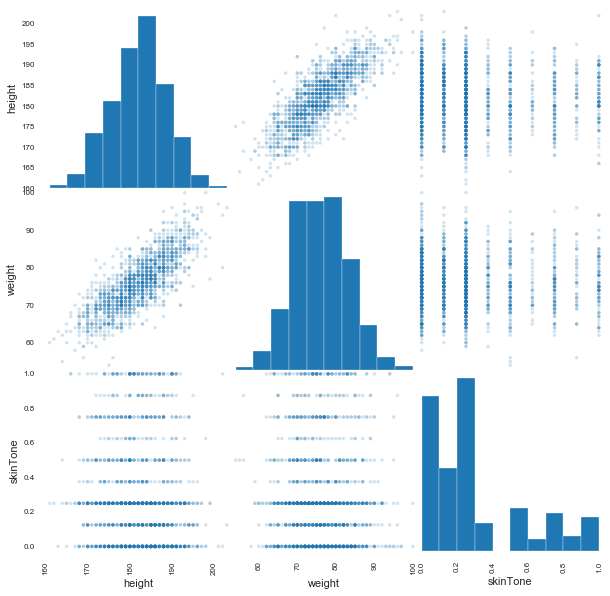

In [39]:
#Examine pair-wise relationships
fig, ax = plt.subplots(figsize=(10,10))
scatter_matrix(players[['height','weight','skinTone']], alpha=0.2, diagonal='hist', ax=ax)

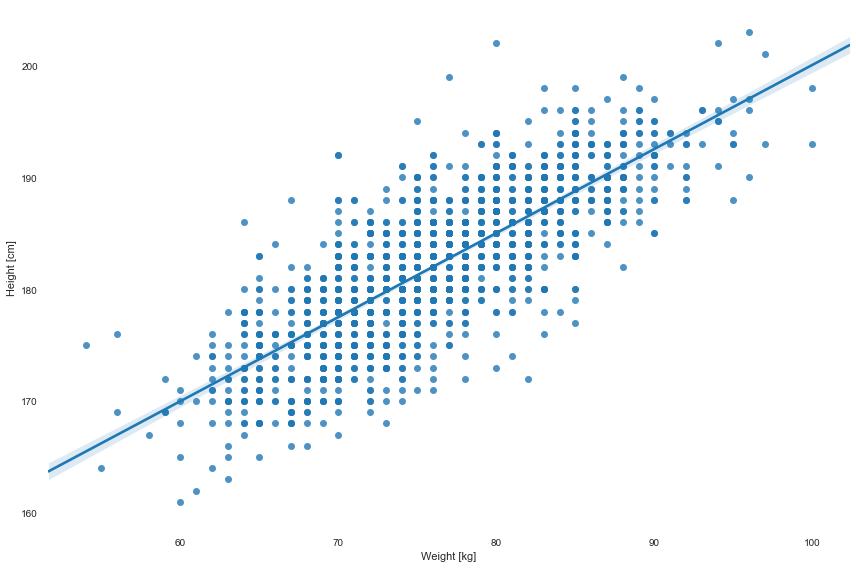

In [40]:
fig, ax = plt.subplots(figsize=MIDSIZE)
sns.regplot('weight', 'height', data=players, ax=ax)
ax.set_ylabel("Height [cm]")
ax.set_xlabel("Weight [kg]")
fig.tight_layout()

### Insight: No outliers. But if we create different classes of heights and weights, can we see any pattern?

In [41]:
weight_classes = [
    'vlow_wt',
    'low_wt',
    'avg_wt',
    'high_wt',
    'vhigh_wt'
]
players['weightClass'] = pd.qcut(players['weight'], len(weight_classes), weight_classes)
players.head()

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  skinTone position_agg  \
playerShort                                                                 
aaron-hughes              3868.jpg    0.25    0.00     0.125      Defence   
aaron-hunt               20136.jpg    0.00    0.25     0.125      Forward   
aaron-lennon             13515.jpg    0.25    0.25     0.250     MidField   
aaron-ramsey             94953.jpg    0.00    0.00     0.000     MidField   
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25     0.250      Defence   

                       weightClass  
playerShort                         
aaron-hughes                low_wt  
aaron-hunt                  low_wt  
aaron-lennon               vlow_wt  
aaron-ramsey                avg_wt  
abdelhamid-el-kaoutari      low_wt

In [42]:
height_classes = [
    'vlow_ht',
    'low_ht',
    'avg_ht',
    'high_ht',
    'vhigh_ht'
]
players['heightClass'] = pd.qcut(players['height'], len(height_classes), height_classes)
players.head()    

birthday  height  weight              position  \
playerShort                                                                
aaron-hughes            08.11.1979   182.0    71.0           Center Back   
aaron-hunt              04.09.1986   183.0    73.0  Attacking Midfielder   
aaron-lennon            16.04.1987   165.0    63.0      Right Midfielder   
aaron-ramsey            26.12.1990   178.0    76.0     Center Midfielder   
abdelhamid-el-kaoutari  17.03.1990   180.0    73.0           Center Back   

                           photoID  rater1  rater2  skinTone position_agg  \
playerShort                                                                 
aaron-hughes              3868.jpg    0.25    0.00     0.125      Defence   
aaron-hunt               20136.jpg    0.00    0.25     0.125      Forward   
aaron-lennon             13515.jpg    0.25    0.25     0.250     MidField   
aaron-ramsey             94953.jpg    0.00    0.00     0.000     MidField   
abdelhamid-el-kaoutari  124913.jpg    0.25    0.25     0.250      Defence   

                       weightClass heightClass  
playerShort                                     
aaron-hughes                low_wt      avg_ht  
aaron-hunt                  low_wt      avg_ht  
aaron-lennon               vlow_wt     vlow_ht  
aaron-ramsey                avg_wt      low_ht  
abdelhamid-el-kaoutari      low_wt      low_ht

### Pandas Profiling

In [43]:
pandas_profiling.ProfileReport(players)

In [44]:
# modifying dataframe
players['birth_date'] = pd.to_datetime(players.birthday, format='%d.%m.%Y')
players['age_years'] = ((pd.to_datetime("2013-01-01") - players['birth_date']).dt.days)/365.25

In [45]:
players_cleaned_variables = [#'birthday',
                             'height',
                             'weight',
#                              'position',
#                              'photoID',
#                              'rater1',
#                              'rater2',
                             
                             'position_agg',
                             'weightClass',
                             'heightClass',
                             'skinTone',
#                              'birth_date',
                             'age_years']

In [46]:
pandas_profiling.ProfileReport(players[players_cleaned_variables])

In [47]:
clean_players = players[players_cleaned_variables]
clean_players.head()

height  weight position_agg weightClass heightClass  \
playerShort                                                                   
aaron-hughes             182.0    71.0      Defence      low_wt      avg_ht   
aaron-hunt               183.0    73.0      Forward      low_wt      avg_ht   
aaron-lennon             165.0    63.0     MidField     vlow_wt     vlow_ht   
aaron-ramsey             178.0    76.0     MidField      avg_wt      low_ht   
abdelhamid-el-kaoutari   180.0    73.0      Defence      low_wt      low_ht   

                        skinTone  age_years  
playerShort                                  
aaron-hughes               0.125  33.149897  
aaron-hunt                 0.125  26.327173  
aaron-lennon               0.250  25.713895  
aaron-ramsey               0.000  22.017796  
abdelhamid-el-kaoutari     0.250  22.795346

In [48]:
dyands.head()

games  victories  ties  defeats  goals  yellowCards  \
refNum playerShort                                                          
1      lucas-wilchez      1          0     0        1      0            0   
2      john-utaka         1          0     0        1      0            1   
3      abdon-prats        1          0     1        0      0            1   
       pablo-mari         1          1     0        0      0            0   
       ruben-pena         1          1     0        0      0            0   

                      yellowReds  redCards  
refNum playerShort                          
1      lucas-wilchez           0         0  
2      john-utaka              0         0  
3      abdon-prats             0         0  
       pablo-mari              0         0  
       ruben-pena              0         0

In [49]:
dyands['totalRedCards'] = dyands['yellowReds'] + dyands['redCards']
dyands.rename(columns={'redCards':'strictRedCards'}, inplace=True)
dyands.head()

games  victories  ties  defeats  goals  yellowCards  \
refNum playerShort                                                          
1      lucas-wilchez      1          0     0        1      0            0   
2      john-utaka         1          0     0        1      0            1   
3      abdon-prats        1          0     1        0      0            1   
       pablo-mari         1          1     0        0      0            0   
       ruben-pena         1          1     0        0      0            0   

                      yellowReds  strictRedCards  totalRedCards  
refNum playerShort                                               
1      lucas-wilchez           0               0              0  
2      john-utaka              0               0              0  
3      abdon-prats             0               0              0  
       pablo-mari              0               0              0  
       ruben-pena              0               0              0

In [50]:
#Remove records for the players who don't have skintone
dyands.reset_index().head()

refNum    playerShort  games  victories  ties  defeats  goals  yellowCards  \
0       1  lucas-wilchez      1          0     0        1      0            0   
1       2     john-utaka      1          0     0        1      0            1   
2       3    abdon-prats      1          0     1        0      0            1   
3       3     pablo-mari      1          1     0        0      0            0   
4       3     ruben-pena      1          1     0        0      0            0   

   yellowReds  strictRedCards  totalRedCards  
0           0               0              0  
1           0               0              0  
2           0               0              0  
3           0               0              0  
4           0               0              0

In [51]:
dyands.reset_index().set_index('playerShort').head()

refNum  games  victories  ties  defeats  goals  yellowCards  \
playerShort                                                                  
lucas-wilchez       1      1          0     0        1      0            0   
john-utaka          2      1          0     0        1      0            1   
abdon-prats         3      1          0     1        0      0            1   
pablo-mari          3      1          1     0        0      0            0   
ruben-pena          3      1          1     0        0      0            0   

               yellowReds  strictRedCards  totalRedCards  
playerShort                                               
lucas-wilchez           0               0              0  
john-utaka              0               0              0  
abdon-prats             0               0              0  
pablo-mari              0               0              0  
ruben-pena              0               0              0

In [54]:
#Merge player & referee
player_dyand = clean_players.merge(
    dyands.reset_index().set_index('playerShort'),
    left_index=True,
    right_index=True
)
player_dyand.head()

height  weight position_agg weightClass heightClass  skinTone  \
playerShort                                                                   
aaron-hughes   182.0    71.0      Defence      low_wt      avg_ht     0.125   
aaron-hughes   182.0    71.0      Defence      low_wt      avg_ht     0.125   
aaron-hughes   182.0    71.0      Defence      low_wt      avg_ht     0.125   
aaron-hughes   182.0    71.0      Defence      low_wt      avg_ht     0.125   
aaron-hughes   182.0    71.0      Defence      low_wt      avg_ht     0.125   

              age_years  refNum  games  victories  ties  defeats  goals  \
playerShort                                                               
aaron-hughes  33.149897       4      1          0     0        1      0   
aaron-hughes  33.149897      66      1          1     0        0      0   
aaron-hughes  33.149897      77     26         13     8        5      0   
aaron-hughes  33.149897     163      2          1     1        0      0   
aaron-hughes  33.149897     194     16          3     5        8      0   

              yellowCards  yellowReds  strictRedCards  totalRedCards  
playerShort                                                           
aaron-hughes            0           0               0              0  
aaron-hughes            0           0               0              0  
aaron-hughes            0           0               0              0  
aaron-hughes            0           0               0              0  
aaron-hughes            2           0               0              0

In [55]:
clean_dyands = (dyands.reset_index()[dyands.reset_index()
                                   .playerShort
                                   .isin(set(clean_players.index))
                                  ]).set_index(['refNum', 'playerShort'])
clean_dyands.head()

games  victories  ties  defeats  goals  \
refNum playerShort                                                  
1      lucas-wilchez           1          0     0        1      0   
2      john-utaka              1          0     0        1      0   
4      aaron-hughes            1          0     0        1      0   
       aleksandar-kolarov      1          1     0        0      0   
       alexander-tettey        1          0     0        1      0   

                           yellowCards  yellowReds  strictRedCards  \
refNum playerShort                                                   
1      lucas-wilchez                 0           0               0   
2      john-utaka                    1           0               0   
4      aaron-hughes                  0           0               0   
       aleksandar-kolarov            0           0               0   
       alexander-tettey              0           0               0   

                           totalRedCards  
refNum playerShort                        
1      lucas-wilchez                   0  
2      john-utaka                      0  
4      aaron-hughes                    0  
       aleksandar-kolarov              0  
       alexander-tettey                0

In [56]:
#Disagreedate the player-referee combo

colnames = ['games', 'totalRedCards']
j = 0
out = [0 for _ in range(sum(clean_dyands['games']))]

for index, row in clean_dyands.reset_index().iterrows():
    n = row['games']
    d = row['totalRedCards']
    ref = row['refNum']
    player = row['playerShort']
    for _ in range(n):
        row['totalRedCards'] = 1 if (d-_) > 0 else 0
        rowlist=list([ref, player, row['totalRedCards']])
        out[j] = rowlist
        j += 1

tidy_dyands = pd.DataFrame(out, columns=['refNum', 'playerShort', 'redcard'],).set_index(['refNum', 'playerShort'])
tidy_dyands.head()

redcard
refNum playerShort                
1      lucas-wilchez             0
2      john-utaka                0
4      aaron-hughes              0
       aleksandar-kolarov        0
       alexander-tettey          0

In [58]:
tidy_dyands.redcard.sum()

3092

In [60]:
clean_dyands.games.sum()

373067

In [61]:
!conda install pivottablejs -y

Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::alabaster==0.7.12=py37_0
  - defaults/win-64::anaconda==2019.10=py37_0
  - defaults/win-64::anaconda-client==1.7.2=py37_0
  - defaults/win-64::anaconda-navigator==1.9.7=py37_0
  - defaults/noarch::anaconda-project==0.8.3=py_0
  - defaults/win-64::asn1crypto==1.0.1=py37_0
  - defaults/win-64::astroid==2.3.1=py37_0
  - defaults/win-64::astropy==3.2.1=py37he774522_0
  - defaults/win-64::atomicwrites==1.3.0=py37_1
  - defaults/noarch::attrs==19.2.0=py_0
  - defaults/noarch::babel==2.7.0=py_0
  - defaults/win-64::backcall==0.1.0=py37_0
  - defaults/noarch::backports==1.0=py_2
  - defaults/noarch::backports.functools_lru_cache==1.5=py_2
  - defaults/win-64::backports.os==0.1.1=py37_0
  - defaults/win-64::backports.shutil_get_terminal_size==1.0.0=py37_2
  - defaults/noarch::backports.tempfile==1.0=py_1
  - defa



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [62]:
from pivottablejs import pivot_ui

In [63]:
temp = tidy_dyands.reset_index().set_index('playerShort').merge(clean_players, left_index=True, right_index=True)

In [64]:
temp.shape

(373067, 9)

In [66]:
# pivot_ui(temp[['skinTone', 'position_agg', 'redcard']], )

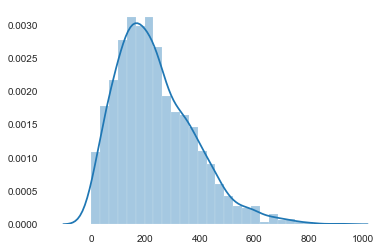

In [67]:
# How many games has each player played in?
games = tidy_dyands.groupby(level=1).count()
sns.distplot(games);

In [68]:
(tidy_dyands.groupby(level=0)
           .count()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total games refereed'})).head()

total games refereed
refNum                      
1214                    5598
2080                    4773
1942                    4469
2398                    4363
3099                    4087

In [70]:
(tidy_dyands.groupby(level=0)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards given'})).head()

total redcards given
refNum                      
468                       49
432                       49
449                       47
916                       42
2073                      36

In [72]:
(tidy_dyands.groupby(level=1)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards received'})).head()

total redcards received
playerShort                              
cyril-jeunechamp                       19
sergio-ramos                           19
gary-medel                             16
ballesteros                            15
juanfran                               15

In [74]:
tidy_dyands.groupby(level=0).size().sort_values(ascending=False)

refNum
1214    5598
2080    4773
1942    4469
2398    4363
3099    4087
        ... 
825        1
824        1
2620       1
2616       1
1          1
Length: 2978, dtype: int64

In [75]:
total_ref_games = tidy_dyands.groupby(level=0).size().sort_values(ascending=False)
total_player_games = tidy_dyands.groupby(level=1).size().sort_values(ascending=False)

In [76]:
total_ref_given = tidy_dyands.groupby(level=0).sum().sort_values(ascending=False,by='redcard')
total_player_received = tidy_dyands.groupby(level=1).sum().sort_values(ascending=False, by='redcard')

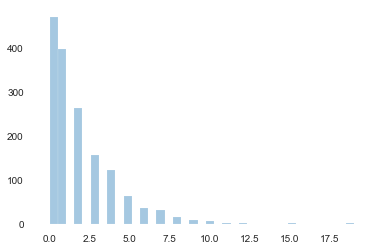

In [78]:
sns.distplot(total_player_received, kde=False)

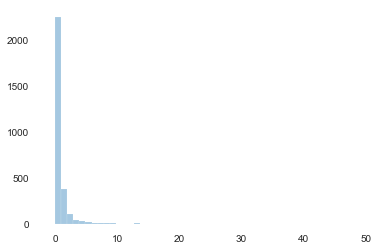

In [79]:
sns.distplot(total_ref_given, kde=False);

In [80]:
tidy_dyands.groupby(level=1).sum().sort_values(ascending=False, by='redcard').head()

redcard
playerShort              
cyril-jeunechamp       19
sergio-ramos           19
gary-medel             16
ballesteros            15
juanfran               15

In [83]:
tidy_dyands.sum(), tidy_dyands.count(), tidy_dyands.sum()/tidy_dyands.count()

(redcard    3092
 dtype: int64, redcard    373067
 dtype: int64, redcard    0.008288
 dtype: float64)

In [85]:
player_ref_game = (tidy_dyands.reset_index()
                               .set_index('playerShort')
                                       .merge(clean_players,
                                              left_index=True,
                                              right_index=True)
                  )

In [86]:
player_ref_game.head()

refNum  redcard  height  weight position_agg weightClass  \
playerShort                                                              
aaron-hughes       4        0   182.0    71.0      Defence      low_wt   
aaron-hughes      66        0   182.0    71.0      Defence      low_wt   
aaron-hughes      77        0   182.0    71.0      Defence      low_wt   
aaron-hughes      77        0   182.0    71.0      Defence      low_wt   
aaron-hughes      77        0   182.0    71.0      Defence      low_wt   

             heightClass  skinTone  age_years  
playerShort                                    
aaron-hughes      avg_ht     0.125  33.149897  
aaron-hughes      avg_ht     0.125  33.149897  
aaron-hughes      avg_ht     0.125  33.149897  
aaron-hughes      avg_ht     0.125  33.149897  
aaron-hughes      avg_ht     0.125  33.149897

In [87]:
bootstrap = pd.concat([player_ref_game.sample(replace=True, 
                                              n=10000).groupby('skinTone').mean() 
                       for _ in range(100)])

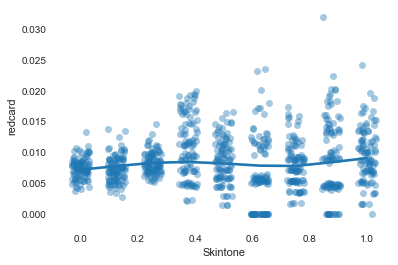

In [88]:
ax = sns.regplot(bootstrap.index.values,
                 y='redcard',
                 data=bootstrap,
                 lowess=True,
                 scatter_kws={'alpha':0.4,},
                 x_jitter=(0.125 / 4.0))
ax.set_xlabel("Skintone");

# Conclusion: skintone does play the *only* role in red cards. 